In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab
import seaborn as sns
import pmdarima as pm
import itertools 
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from pmdarima import auto_arima
color_pal = sns.color_palette()
from flask import Flask, request, jsonify
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings 
warnings.filterwarnings('ignore')


# LOADING AND VIEWING DATA

In [2]:
# Loading the dataset using def fuction and making sure of few things like:
#parse_dates enables pandas to understand that it is a date and not string
def gb_carbon():
    # Read the CSV file and parse the dates
    data = pd.read_csv('gb_carbon_intensity.csv', parse_dates=True)
    data.set_index('datetime', inplace=True)
    return data

CO2 =gb_carbon()
print(CO2.head()) #checking the first data

                     forecast  actual index
datetime                                   
2018-01-01T00:00:00     154.0   157.0   low
2018-01-01T00:30:00     159.0   164.0   low
2018-01-01T01:00:00     169.0   171.0   low
2018-01-01T01:30:00     170.0   172.0   low
2018-01-01T02:00:00     165.0   172.0   low


In [3]:
print(CO2.tail()) #checking the last five data

                     forecast  actual index
datetime                                   
2024-08-04T00:00:00       NaN     NaN   NaN
2024-08-04T00:30:00       NaN     NaN   NaN
2024-08-04T01:00:00       NaN     NaN   NaN
2024-08-04T01:30:00       NaN     NaN   NaN
2024-08-04T02:00:00       NaN     NaN   NaN


In [4]:
print(CO2.info()) #Checking the information of each columns

<class 'pandas.core.frame.DataFrame'>
Index: 115541 entries, 2018-01-01T00:00:00 to 2024-08-04T02:00:00
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   forecast  112683 non-null  float64
 1   actual    111851 non-null  float64
 2   index     112683 non-null  object 
dtypes: float64(2), object(1)
memory usage: 3.5+ MB
None


# DATA CLEANING

In [6]:
#The datetime shows a timespam of 30minutes interval and I will split it based on that
# 30min, 1 hour, day_of_week, month, quarter, year, day_of_year.
def create_timespam(CO2):
    if not pd.api.types.is_datetime64_any_dtype(CO2.index):
        CO2.index = pd.to_datetime(CO2.index)
        
    CO2['30mi'] = CO2.index.floor('30T').time # this is to split it into 30min but it will be an object instead of a float
    CO2['30min'] = CO2['30mi'].apply(lambda x: x.hour * 60 + x.minute + x.second / 60) #For the 30mins to be a float
    CO2.drop(columns=['30mi'], inplace=True)
    CO2['hour'] = CO2.index.hour
    CO2['dayofweek'] = CO2.index.dayofweek
    CO2['month'] = CO2.index.month
    CO2['quarter'] = CO2.index.quarter
    CO2['year'] = CO2.index.year
    CO2['dayofyear'] = CO2.index.dayofyear
    # Every other time split will have the right datatype 
    return CO2
CO2 = create_timespam(CO2)
CO2.head()

,forecast,actual,index,30min,hour,dayofweek,month,quarter,year,dayofyear
datetime,,,,,,,,,,
2018-01-01 00:00:00,154.0,157.0,low,0.0,0,0,1,1,2018,1
2018-01-01 00:30:00,159.0,164.0,low,30.0,0,0,1,1,2018,1
2018-01-01 01:00:00,169.0,171.0,low,60.0,1,0,1,1,2018,1
2018-01-01 01:30:00,170.0,172.0,low,90.0,1,0,1,1,2018,1
2018-01-01 02:00:00,165.0,172.0,low,120.0,2,0,1,1,2018,1


In [7]:
#I have to drop, forecast and the index columns  
CO2.drop(columns=['forecast', 'index'], inplace=True)
# print(CO2.head())
CO2.head()

,actual,30min,hour,dayofweek,month,quarter,year,dayofyear
datetime,,,,,,,,
2018-01-01 00:00:00,157.0,0.0,0,0,1,1,2018,1
2018-01-01 00:30:00,164.0,30.0,0,0,1,1,2018,1
2018-01-01 01:00:00,171.0,60.0,1,0,1,1,2018,1
2018-01-01 01:30:00,172.0,90.0,1,0,1,1,2018,1
2018-01-01 02:00:00,172.0,120.0,2,0,1,1,2018,1


In [8]:
CO2.tail()

,actual,30min,hour,dayofweek,month,quarter,year,dayofyear
datetime,,,,,,,,
2024-08-04 00:00:00,NaN,0.0,0,6,8,3,2024,217
2024-08-04 00:30:00,NaN,30.0,0,6,8,3,2024,217
2024-08-04 01:00:00,NaN,60.0,1,6,8,3,2024,217
2024-08-04 01:30:00,NaN,90.0,1,6,8,3,2024,217
2024-08-04 02:00:00,NaN,120.0,2,6,8,3,2024,217


In [9]:
#Seeing that some rows has 'NaN' I will remove the empyt rows 'NaN'
#These NaNs rows was created but had not yet been retrived when the data was downloaded from the website
CO2.dropna(inplace=True)
CO2.tail()

,actual,30min,hour,dayofweek,month,quarter,year,dayofyear
datetime,,,,,,,,
2024-07-04 22:30:00,54.0,1350.0,22,3,7,3,2024,186
2024-07-04 23:00:00,53.0,1380.0,23,3,7,3,2024,186
2024-07-04 23:30:00,55.0,1410.0,23,3,7,3,2024,186
2024-07-05 00:00:00,54.0,0.0,0,4,7,3,2024,187
2024-07-05 00:30:00,55.0,30.0,0,4,7,3,2024,187


In [10]:
# I want to check if there is still NaN's in the dataset
CO2_has_nan = CO2.isnull().values.any()
print(f"Does the dataset have NaN values? {CO2_has_nan}") # to reconfirm if there is still any 'NaNs'

Does the dataset have NaN values? False


# PERFORM SPECIFIC DATA ANALYSIS (SDA)

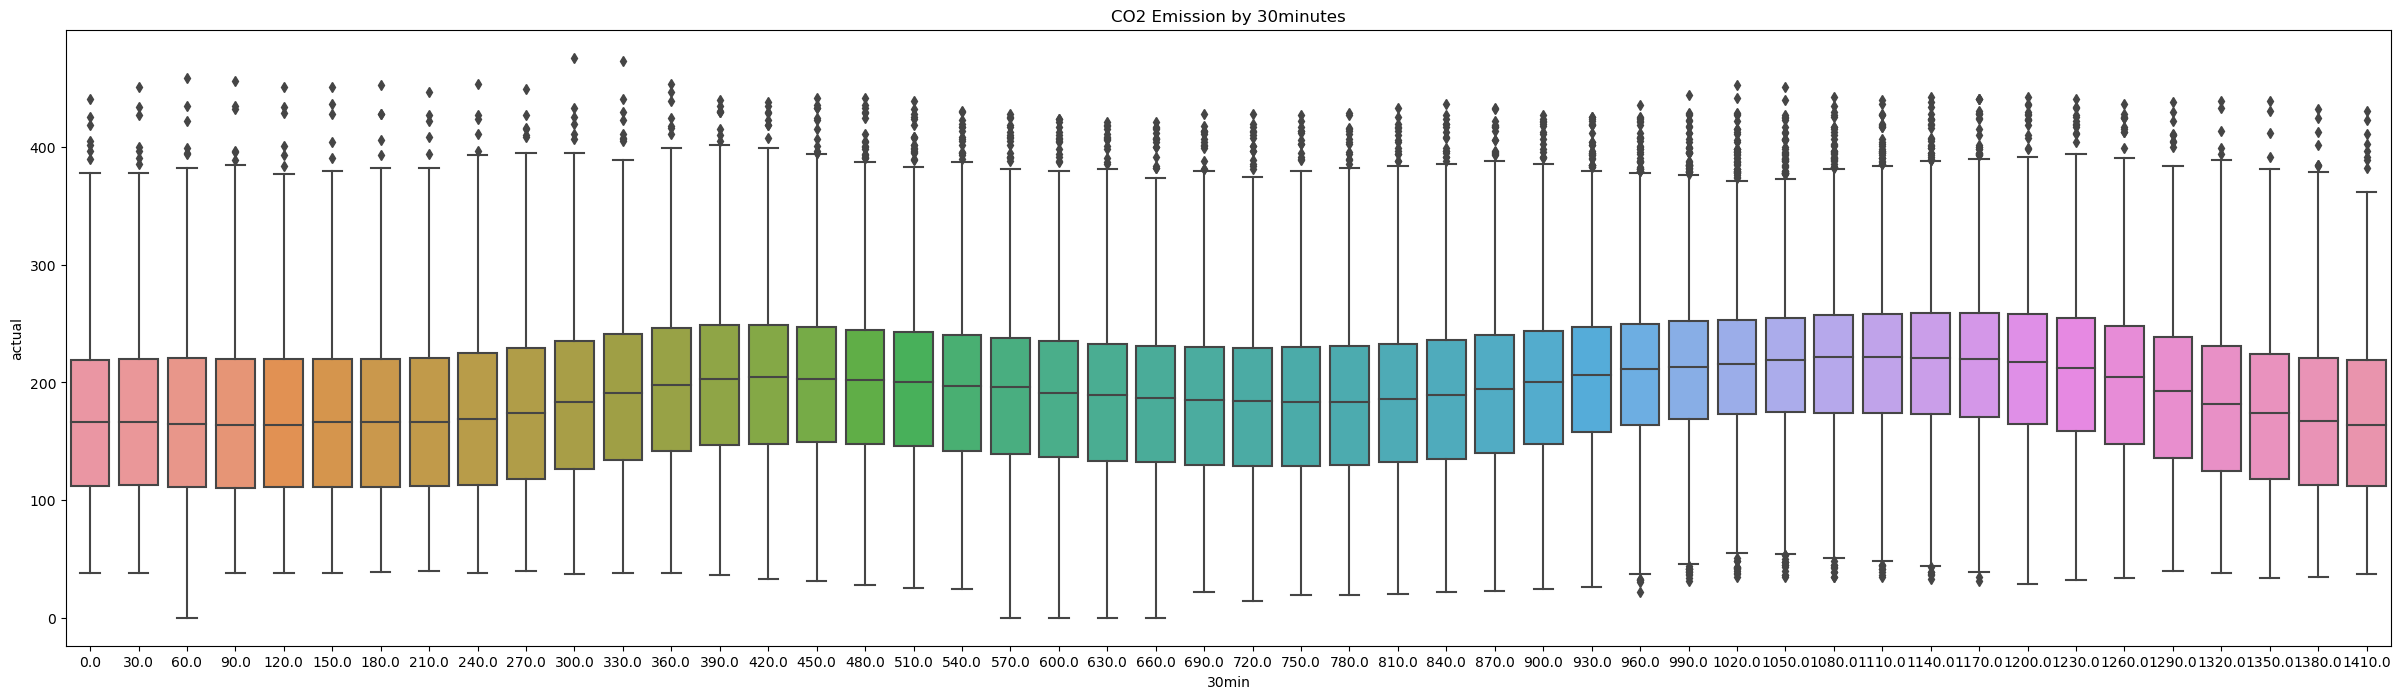

In [11]:
fig, ax = plt.subplots(figsize=(30,8))
sns.boxplot(data=CO2, x='30min', y='actual')
ax.set_title('CO2 Emission by 30minutes')
plt.show()

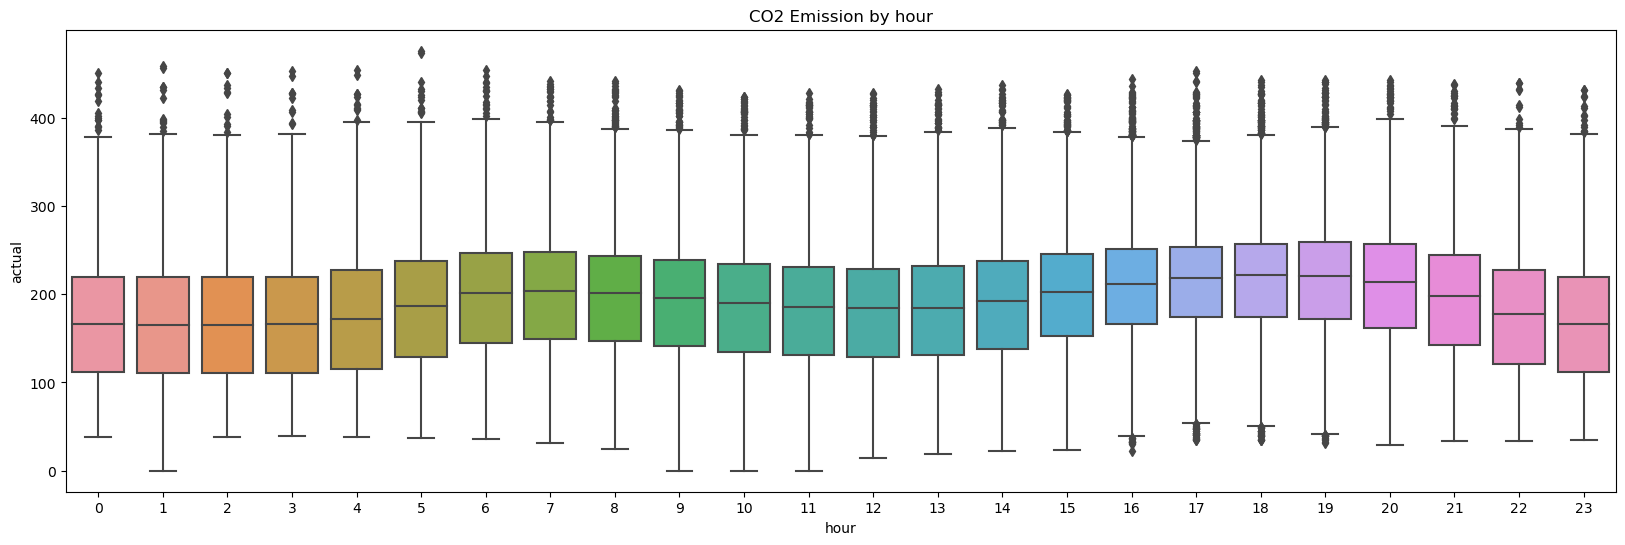

In [12]:
fig, ax = plt.subplots(figsize=(20,6))
sns.boxplot(data=CO2, x='hour', y='actual')
ax.set_title('CO2 Emission by hour')
plt.show()


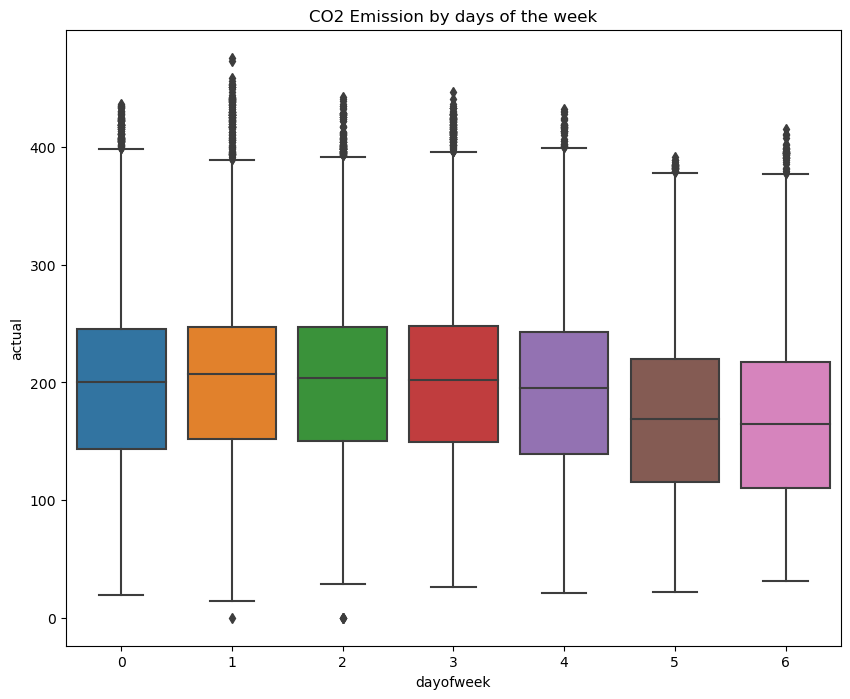

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=CO2, x='dayofweek', y='actual')
ax.set_title('CO2 Emission by days of the week')
plt.show()

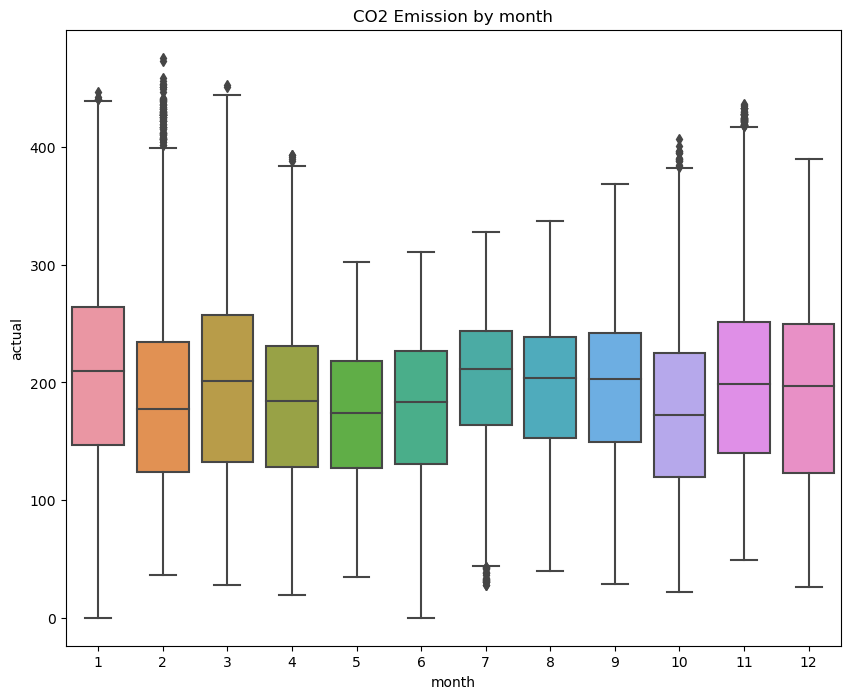

In [14]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=CO2, x='month', y='actual')
ax.set_title('CO2 Emission by month')
plt.show()

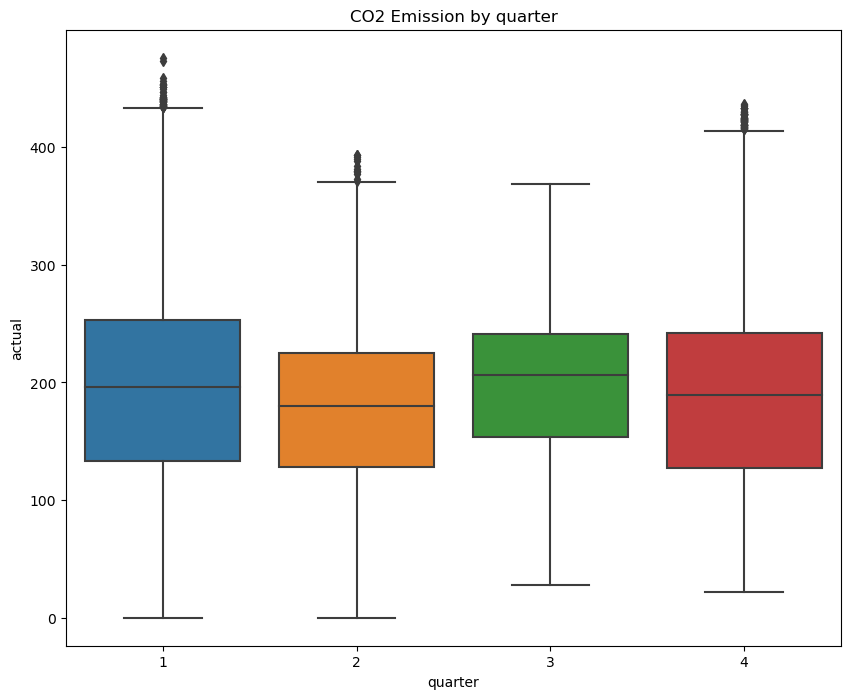

In [15]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=CO2, x='quarter', y='actual')
ax.set_title('CO2 Emission by quarter')
plt.show()

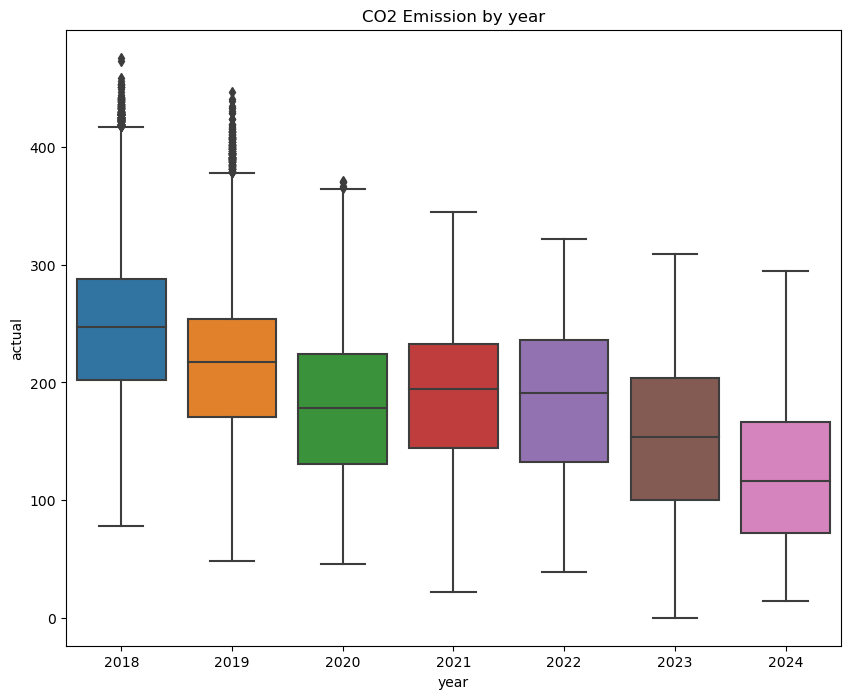

In [16]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=CO2, x='year', y='actual')
ax.set_title('CO2 Emission by year')
plt.show()

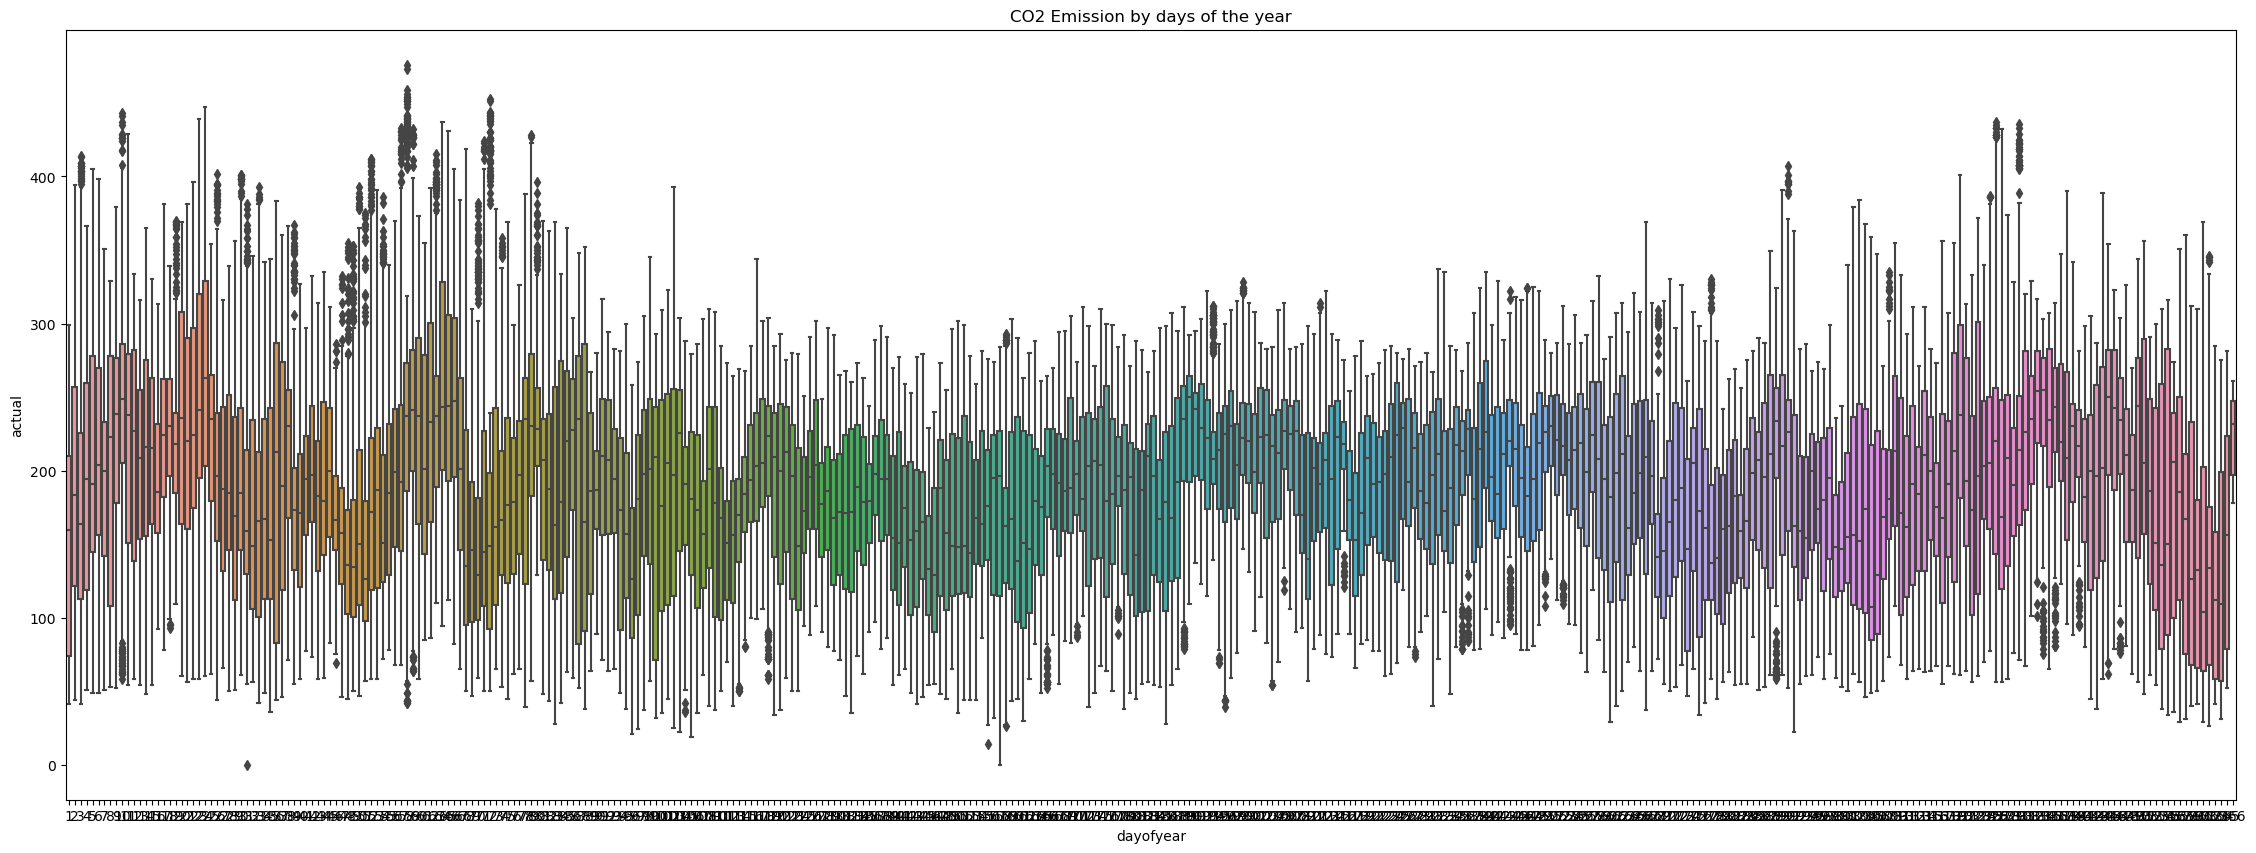

In [17]:
fig, ax = plt.subplots(figsize=(28,10))
sns.boxplot(data=CO2, x='dayofyear', y='actual')
ax.set_title('CO2 Emission by days of the year')
plt.show()

# TO DETERMINE IF THE DATA IS STATIONARY OR NOT

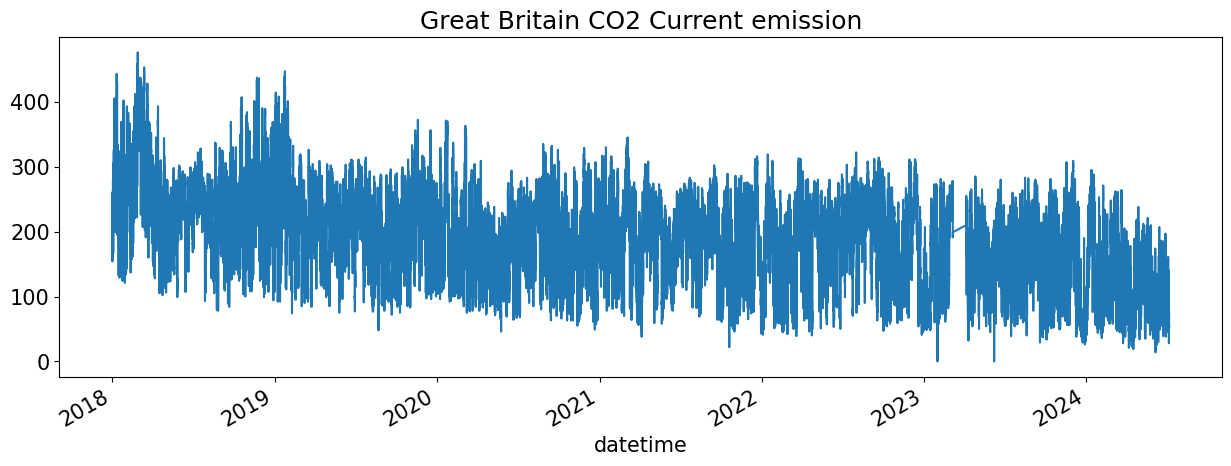

In [18]:
# METHOD 1: using visualization to see if the data (the 'actual' column which is my focus) is stationary or not

plt.rcParams['font.size'] = 15
CO2['actual'].plot(figsize=(15,5), color=color_pal[0], title = 'Great Britain CO2 Current emission');
plt.show()

In [19]:
#METHOD 2: using adfuller to determine if the 'actual' column is stationary or not

def stationarity_check(actual):
    """
    Check if the 'actual' column is stationary  using function.
    """
    # Performed the Augmented Dickey-Fuller test
    result = adfuller(actual, autolag = 'AIC')
    print('1. ADF :', result[0])
    print('2. P_value: ', result[1])
    print('3. Num. of Lags: ', result[2])
    print('4. Num. of observation: ', result[3])
    print('5. Critical value :')
    for key, values in result[4].items():
        print('\t', key, ': ', values)
    
    # To determine from the result of p-value if 'actual' column is stationary or not
    if result[1] < 0.05:
        print("The actual column is stationary (Therefore, reject null hypothesis)")
    else:
        print("The actual column is non-stationary (Therefore, fail to reject null hypothesis)")
        
stationarity_check(CO2['actual'])


1. ADF : -18.210545167937305
2. P_value:  2.3933253067589437e-30
3. Num. of Lags:  70
4. Num. of observation:  111780
5. Critical value :
	 1% :  -3.4304085028643434
	 5% :  -2.861565857379506
	 10% :  -2.5667837629730696
The actual column is stationary (Therefore, reject null hypothesis)


# CREATING TIME SERIES MODELS

### SPLIT THE DATA INTO TRAIN AND TEST

In [20]:
#Time Series Cross Validation to split the data
#The goal is to get 30-minute intervals in the last 3 months
tss = TimeSeriesSplit(n_splits=5, test_size=4320, gap=48) #The split is done with 30 min interval to predict the last 3 months
CO2 = CO2.sort_index()

In [21]:
#This to get my train and validation index using the timeseriessplit i used in the previous cell
for arima_train_idex, arima_vali_idex in tss.split(CO2):
    break 

In [22]:
#My train index output
arima_train_idex

array([    0,     1,     2, ..., 90200, 90201, 90202])

In [23]:
#my validation(test) index output
arima_vali_idex

array([90251, 90252, 90253, ..., 94568, 94569, 94570])

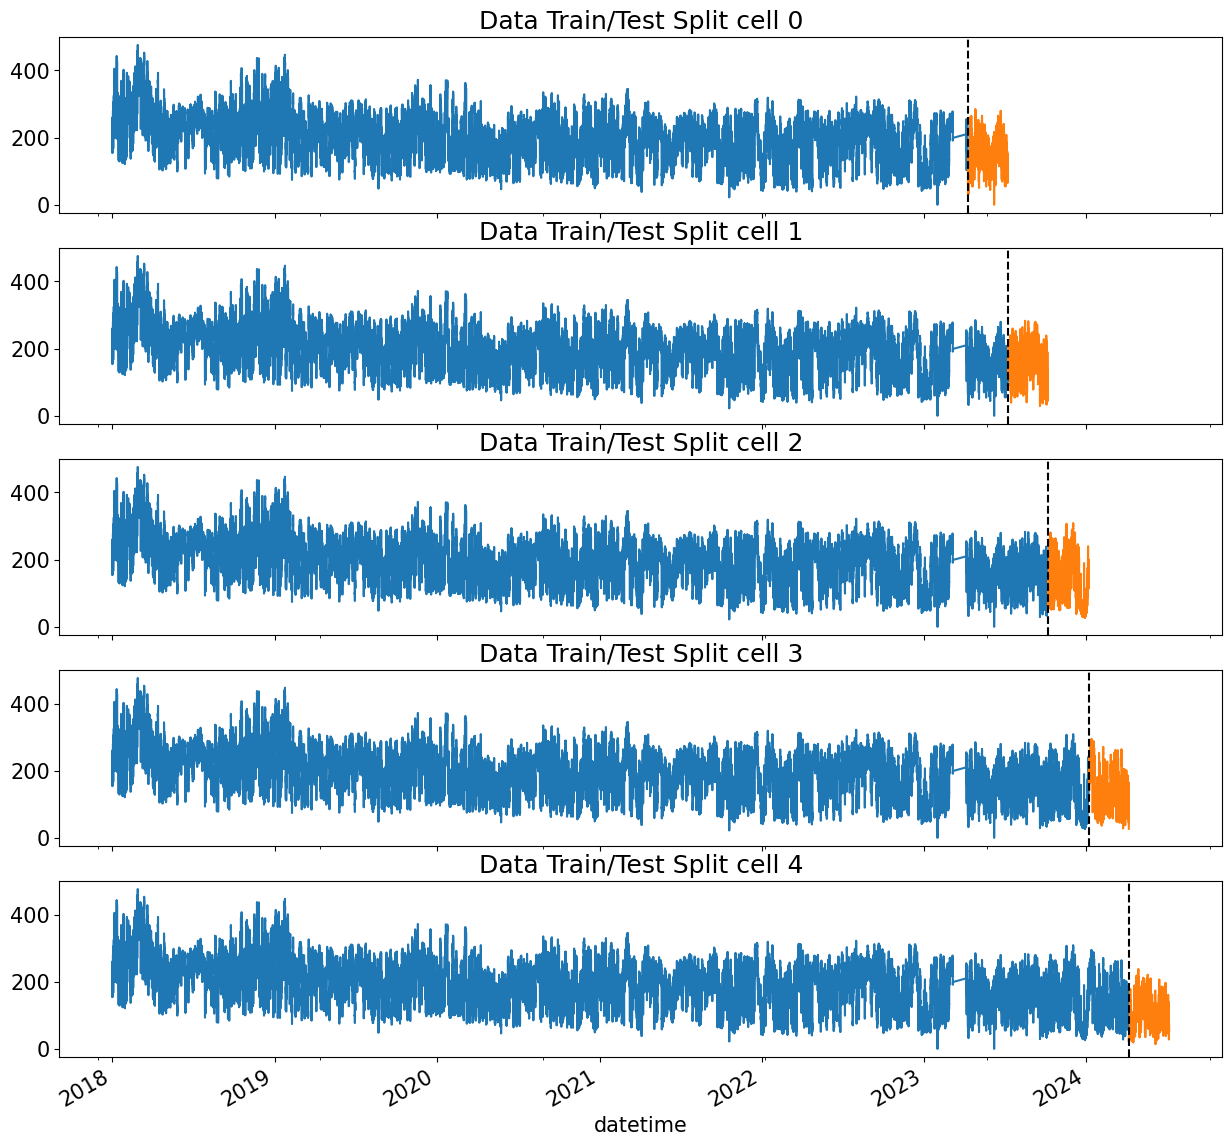

In [24]:
#TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5, test_size=4320, gap=48)
CO2 = CO2.sort_index()

for arima_train_idex, arima_vali_idex in tss.split(CO2):
    break 

# Visualizing my TimeSeriesSplit
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

cell = 0
splits = []
for arima_train_index, arima_test_index in tss.split(CO2):
    arima_train = CO2.iloc[arima_train_index]
    arima_test = CO2.iloc[arima_test_index]
    splits.append((arima_train, arima_test)) 
    
    arima_train['actual'].plot(ax=axs[cell], label='Training Set', title=f'Data Train/Test Split cell {cell}')
    arima_test['actual'].plot(ax=axs[cell], label='Test Set')
    axs[cell].axvline(arima_test.index.min(), color='black', ls='--')
    cell += 1

plt.show()


In [25]:
#This helps me to get all the possible comnibation in the list element
p = range(0, 2)
d = range(0, 2)
q = range(0, 2)

pdq = list(itertools.product(p, d, q))


seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print(seasonal_pdq)

[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [26]:

# Placeholder for my data
CO2 = CO2['actual']

# search over the parameters above
for param in pdq:
    for param_sea in seasonal_pdq:
        try:
            # my model section
            model = sm.tsa.statespace.SARIMAX(CO2,
                                             order=param,
                                             seasonal_order=param_sea,
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)
            # model fit
            results = model.fit()
            # results output
            print(f'SARIMAX{param}x{param_sea} - AIC: {results.aic}')
        except Exception as e:
            # Print the exception if any occurs
            print(f'Error for SARIMAX{param}x{param_sea}: {e}')
            continue


SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC: 1504986.0795165799
SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC: 1402264.2014784038
SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC: 1173017.3408995133
SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC: 1158470.709776517
SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC: 1171577.4074187668
SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC: 1172935.7940844116
SARIMAX(0, 0, 0)x(1, 1, 0, 12) - AIC: 1162781.0193592391
SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC: 1155574.8127565575
SARIMAX(0, 0, 1)x(0, 0, 0, 12) - AIC: 1353241.0549008232
SARIMAX(0, 0, 1)x(0, 0, 1, 12) - AIC: 1251430.3959913892
SARIMAX(0, 0, 1)x(0, 1, 0, 12) - AIC: 1029593.5474175344
SARIMAX(0, 0, 1)x(0, 1, 1, 12) - AIC: 1016738.2243000668
SARIMAX(0, 0, 1)x(1, 0, 0, 12) - AIC: 1028280.1415743335
SARIMAX(0, 0, 1)x(1, 0, 1, 12) - AIC: 1162859.9307968314
SARIMAX(0, 0, 1)x(1, 1, 0, 12) - AIC: 1020356.8478429099
SARIMAX(0, 0, 1)x(1, 1, 1, 12) - AIC: 1013522.4075267555
SARIMAX(0, 1, 0)x(0, 0, 0, 12) - AIC: 763689.8120795027
SARIMAX(0, 1, 0)x(0, 0, 1, 12) - 

FITTING THE BEST PARAMETER INTO THE MODEL

In [27]:
# Based on the training above, the best  is SARIMAX(1, 1, 1)x(1, 0, 1, 12) - AIC: 708999.2968599194
# Define the model with the identified best parameters
arima_best_model = sm.tsa.statespace.SARIMAX(CO2,
                                             order=(1, 1, 1),
                                             seasonal_order=(1, 0, 1, 12),
                                             enforce_stationarity=False,
                                             enforce_invertibility=False)

# Fit the model
results = arima_best_model.fit()

# Print the summary of the model
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             actual   No. Observations:               111851
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood             -354494.648
Date:                            Mon, 12 Aug 2024   AIC                         708999.297
Time:                                    22:21:27   BIC                         709047.421
Sample:                                         0   HQIC                        709013.828
                                         - 111851                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6108      0.003    229.517      0.000       0.606       0.616
ma.L1         -0.1528      0.003   

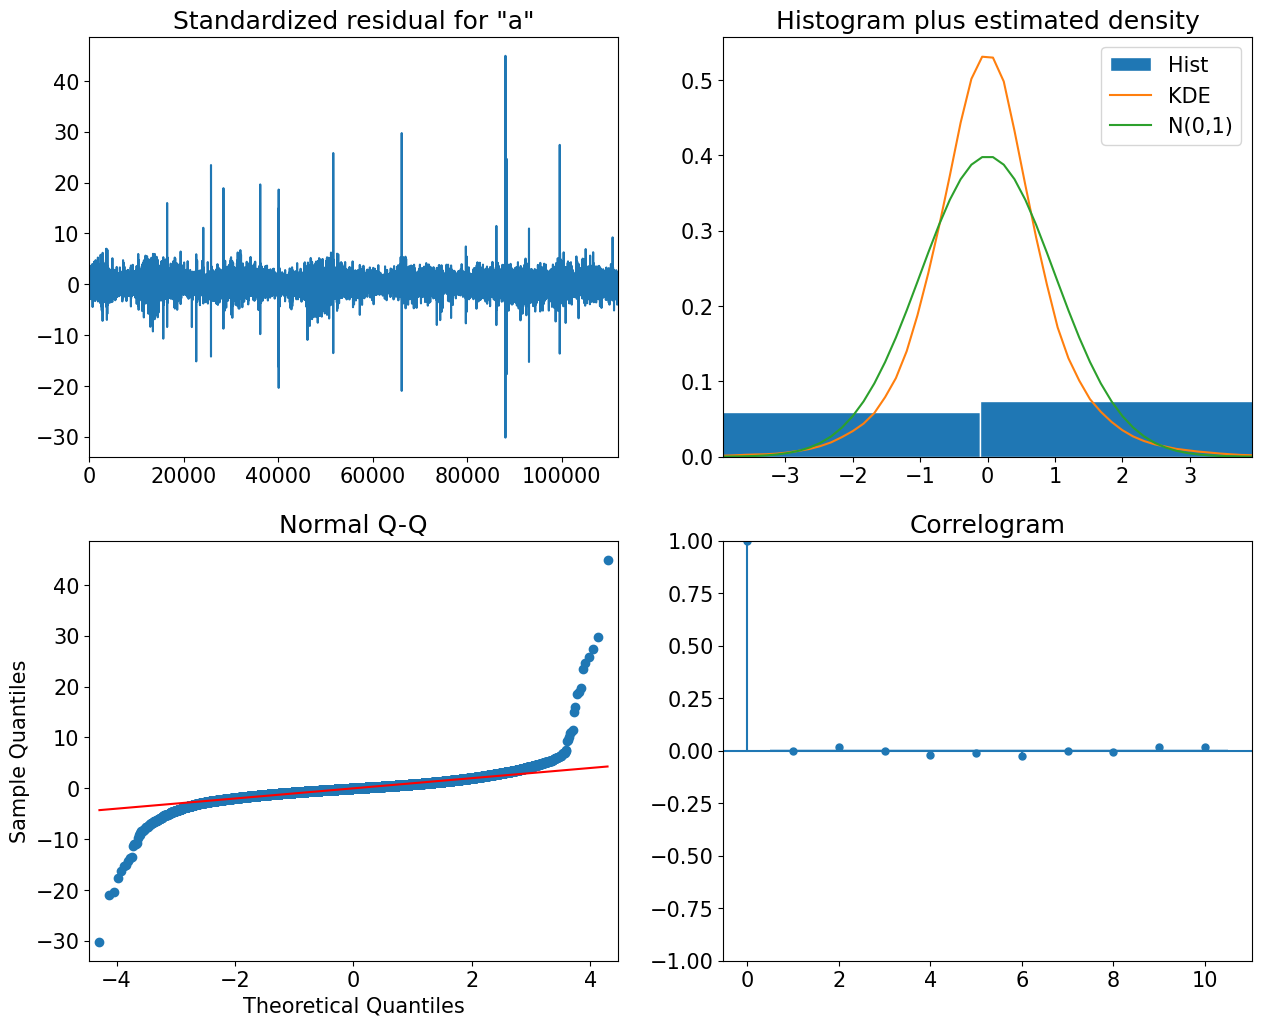

In [29]:
#diagnostics to see how the data plays out
results.plot_diagnostics(figsize=(15,12))
plt.show()

In [30]:
# Checking for confidence interval (lower and upper values )
# May is the starting of my 3 month. my data ends in July based on the data
# so, i want to predict from May... 
pred =results.get_prediction(start=pd.to_datetime('2024-05-07 00:00:00'), dynamic=False) 
pred_ci =pred.conf_int()
pred_ci

,lower actual,upper actual
datetime,,
2024-05-07 00:00:00,143.463788,166.036952
2024-05-07 00:30:00,145.743489,168.316653
2024-05-07 01:00:00,148.343062,170.916226
2024-05-07 01:30:00,146.927201,169.500365
2024-05-07 02:00:00,153.801218,176.374382
...,...,...
2024-07-04 22:30:00,36.368003,58.941167
2024-07-04 23:00:00,41.825711,64.398875
2024-07-04 23:30:00,41.228223,63.801387


In [31]:
# I want to predict the last 3 months and compare it with actual value to see the accuracy
start_date = '2024-05-07' #start of my testing part

# Get in-sample predictions from the test date onwards
pred = results.get_prediction(start=start_date, dynamic=False)

# Extract the predicted mean values
y_predicted = pred.predicted_mean

# Actual values from the starting date onwards
y_truth = CO2[start_date:].copy()

# Combining actual and predicted values to see side by side comparison
CO2_comparison = pd.DataFrame({
    'actual': y_truth,
    'predicted': y_predicted
})

# Display the comparison
print(CO2_comparison)


                     actual   predicted
datetime                               
2024-05-07 00:00:00   156.0  154.750370
2024-05-07 00:30:00   158.0  157.030071
2024-05-07 01:00:00   157.0  159.629644
2024-05-07 01:30:00   161.0  158.213783
2024-05-07 02:00:00   160.0  165.087800
...                     ...         ...
2024-07-04 22:30:00    54.0   47.654585
2024-07-04 23:00:00    53.0   53.112293
2024-07-04 23:30:00    55.0   52.514805
2024-07-05 00:00:00    54.0   55.523294
2024-07-05 00:30:00    55.0   54.394749

[2803 rows x 2 columns]


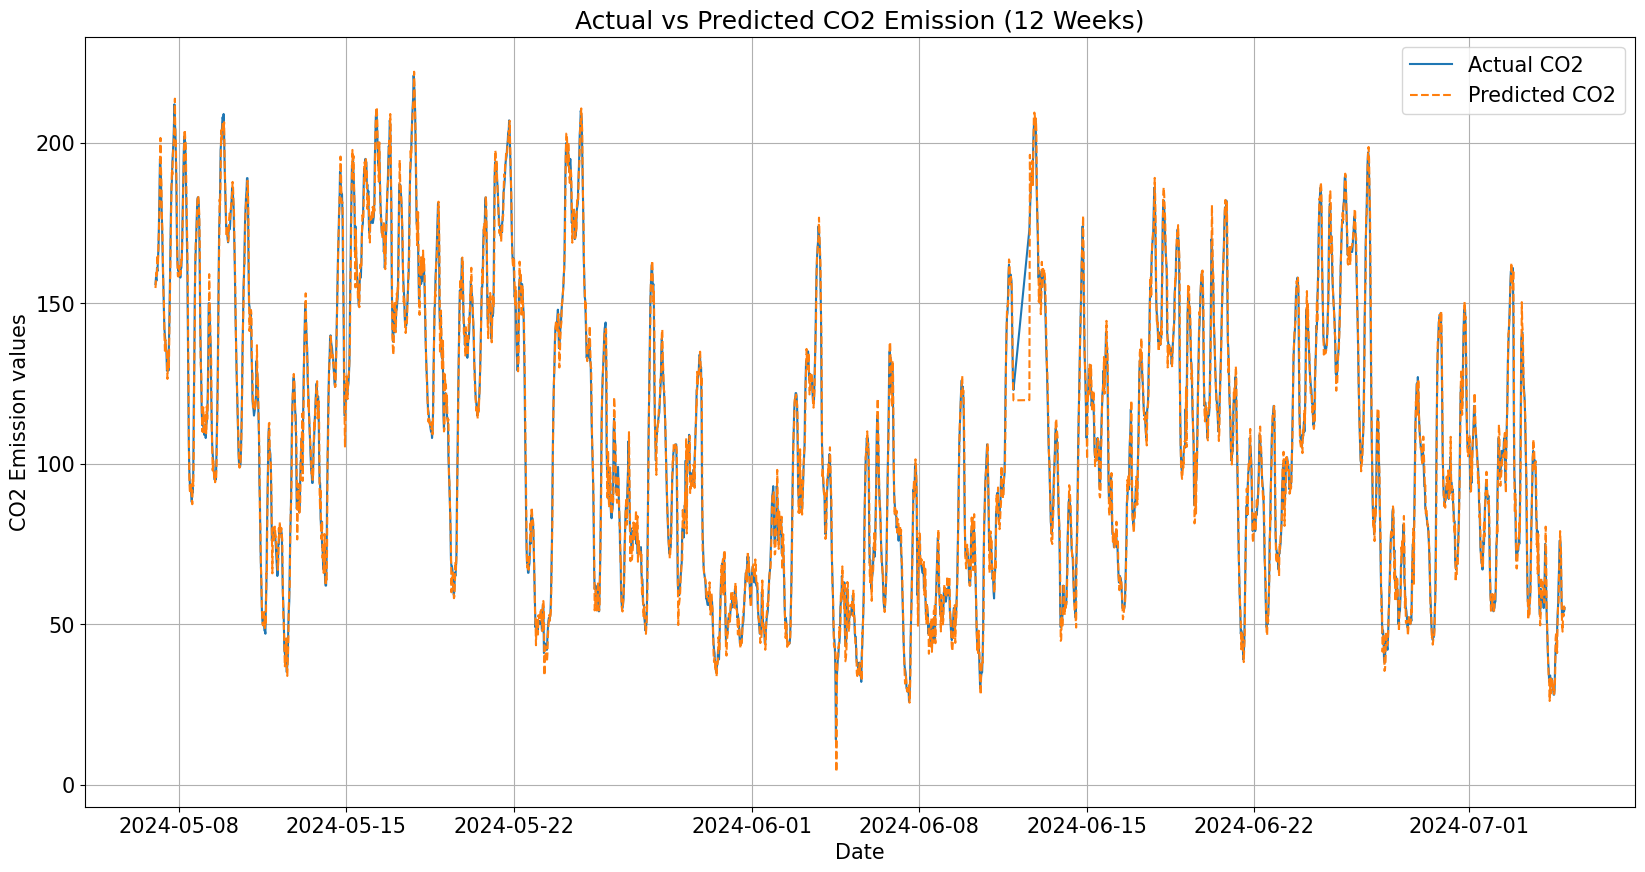

In [32]:
# To visualize Twelve-weeks period to see how well the model performed
start_date = '2024-05-07'

# Filter my data for the Twelve-weeks period
end_date = pd.to_datetime(start_date) + pd.DateOffset(weeks=12)
Twelve_weeks_CO2 = CO2_comparison[start_date:end_date]

# Plotting the actual vs predicted values for Twelve weeks
plt.figure(figsize=(20, 10))
plt.plot(Twelve_weeks_CO2.index, Twelve_weeks_CO2['actual'], label='Actual CO2')
plt.plot(Twelve_weeks_CO2.index, Twelve_weeks_CO2['predicted'], label='Predicted CO2', linestyle='--')
plt.title('Actual vs Predicted CO2 Emission (12 Weeks)')
plt.xlabel('Date')
plt.ylabel('CO2 Emission values')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Extract actual and predicted values to enable me calculate the accurancy
y_actual = CO2_comparison['actual']
y_predicted = CO2_comparison['predicted']

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_actual, y_predicted)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_actual, y_predicted)

# Calculate R-squared (R²)
r2 = r2_score(y_actual, y_predicted)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Print the metrics
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-squared (R²): {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Mean Squared Error (MSE): 22.9993
Mean Absolute Error (MAE): 3.4651
R-squared (R²): 0.9885
Root Mean Squared Error (RMSE): 4.7958


In [34]:
# To  get my baseline from the actual and compare it with the ARIMA result 

# Get the last observed value in the training set
last_observed_value = CO2[start_date].iloc[-1]

# Create a baseline prediction for the same length as the test period
baseline_pred = [last_observed_value] * len(y_actual)


In [35]:
# baseline for MSE
mse_baseline = mean_squared_error(y_actual, baseline_pred)
print(f"MSE Baseline  (Naive Forecast): {mse_baseline:.4f}")

# baseline for MAE
mae_baseline = mean_absolute_error(y_actual, baseline_pred)
print(f"MAE Baseline  (Naive Forecast): {mae_baseline:.4f}")

# baseline for R-squared
r2_baseline = r2_score(y_actual, baseline_pred)
print(f"R-squared Baseline (Naive Forecast): {r2_baseline:.4f}")


# # baseline for RMSE
rmse_baseline = np.sqrt(mean_squared_error(y_actual, baseline_pred))
print(f"Baseline RMSE (Naive Forecast): {rmse_baseline:.4f}")


MSE Baseline  (Naive Forecast): 4762.7902
MAE Baseline  (Naive Forecast): 58.7710
R-squared Baseline (Naive Forecast): -1.3861
Baseline RMSE (Naive Forecast): 69.0130


In [36]:
# Calculate and print all baseline metrics
mse_baseline = mean_squared_error(y_actual, baseline_pred)
mae_baseline = mean_absolute_error(y_actual, baseline_pred)
r2_baseline = r2_score(y_actual, baseline_pred)
rmse_baseline = np.sqrt(mean_squared_error(y_actual, baseline_pred))


# Compare ARIMA with baseline 
print(f"1. MSE Baseline  (Naive Forecast): {mse_baseline:.4f}")
print(f"1. ARIMA's Mean Squared Error (MSE): {mse:.4f}")


print(f"2. MAE Baseline  (Naive Forecast): {mae_baseline:.4f}")
print(f"2. ARIMA's Mean Absolute Error (MAE): {mae:.4f}")


print(f"3. R-squared Baseline  (Naive Forecast): {r2_baseline:.4f}")
print(f"3. ARIMA's R-squared (R²): {r2:.4f}")

print(f"4. RMSE Baseline  (Naive Forecast): {rmse_baseline:.4f}")
print(f"4. ARIMA's Root Mean Squared Error (RMSE): {rmse:.4f}")


1. MSE Baseline  (Naive Forecast): 4762.7902
1. ARIMA's Mean Squared Error (MSE): 22.9993
2. MAE Baseline  (Naive Forecast): 58.7710
2. ARIMA's Mean Absolute Error (MAE): 3.4651
3. R-squared Baseline  (Naive Forecast): -1.3861
3. ARIMA's R-squared (R²): 0.9885
4. RMSE Baseline  (Naive Forecast): 69.0130
4. ARIMA's Root Mean Squared Error (RMSE): 4.7958


# The END